In [1]:
import geopandas as gpd
from shapely.geometry import LineString
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
ice_gdf = gpd.read_parquet("output/icesat2_dems_with_deltas.parquet")

In [3]:
print(ice_gdf.columns)

Index(['region', 'gt', 'spacecraft_velocity', 'solar_elevation', 'rgt',
       'ph_index', 'height', 'atl08_class', 'spot', 'x_atc', 'y_atc', 'cycle',
       'atl03_cnf', 'background_rate', 'quality_ph', 'geometry',
       'geoid_height', 'orthometric_height', 'dem_alos_dem', 'dem_aster_dem',
       'dem_copernicus_dеm', 'dem_fab_dem', 'dem_nasa_dem', 'dem_srtm_dem',
       'h_alos_dem', 'delta_alos_dem', 'h_aster_dem', 'delta_aster_dem',
       'h_copernicus_dеm', 'delta_copernicus_dеm', 'h_fab_dem',
       'delta_fab_dem', 'h_nasa_dem', 'delta_nasa_dem', 'h_srtm_dem',
       'delta_srtm_dem', 'h_tan_dem', 'delta_tan_dem'],
      dtype='object')


In [4]:
print(ice_gdf.head())


   region  gt  spacecraft_velocity  solar_elevation  rgt  ph_index  \
0       6  50          7108.268555       -32.253899  998    123494   
1       6  50          7108.268555       -32.253899  998    123497   
2       6  50          7108.268555       -32.253899  998    123498   
3       6  50          7108.268555       -32.253899  998    123499   
4       6  50          7108.268555       -32.253899  998    123500   

       height  atl08_class  spot         x_atc  ...  h_copernicus_dеm  \
0  637.587952            3     5  1.472135e+07  ...        576.345886   
1  615.246338            2     5  1.472135e+07  ...        576.345886   
2  646.714050            3     5  1.472136e+07  ...        609.472473   
3  650.420288            3     5  1.472136e+07  ...        609.472473   
4  647.244324            2     5  1.472136e+07  ...        609.472473   

   delta_copernicus_dеm   h_fab_dem  delta_fab_dem  h_nasa_dem delta_nasa_dem  \
0            -26.111065  573.288818     -29.168133  584.655

In [5]:
ice_gdf.index = pd.to_datetime(ice_gdf.index)


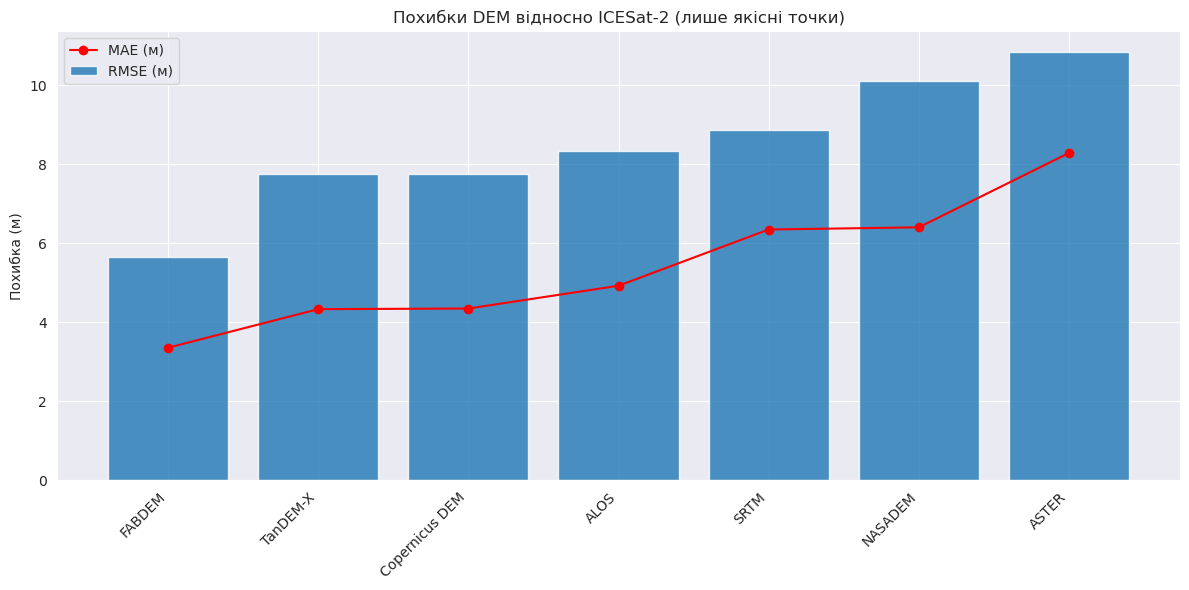

In [6]:

# --- Фільтрація якісних даних (Spot 3, RGT 396, надійні фотони) ---
filtered = ice_gdf[
    # (ice_gdf["rgt"] == 396) &
    # (ice_gdf["spot"] == 3) &
    (ice_gdf["atl03_cnf"] == 4) &
    (ice_gdf["atl08_class"].isin([1]))
].copy()

# Додаємо дату
filtered["date"] = filtered.index.date
dates = sorted(filtered["date"].unique())


# --- Збір статистики по DEM ---
delta_cols = [col for col in filtered.columns if col.startswith("delta_")]

dem_results = []

for col in delta_cols:
    name = col.replace("delta_", "")
    subset = filtered[col].dropna()
    if len(subset) < 10:
        continue
    mae = np.mean(np.abs(subset))
    rmse = np.sqrt(np.mean(subset**2))
    dem_results.append((name, len(subset), mae, rmse))

# --- Побудова графіку RMSE та MAE ---
dem_results.sort(key=lambda x: x[3])  # Сортування за RMSE

dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dеm": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}

# Використовуємо .get() для заміни або повертаємо оригінальну назву, якщо мапи немає
labels = [dem_name_map.get(x[0], x[0]) for x in dem_results]
counts = [x[1] for x in dem_results]
maes = [x[2] for x in dem_results]
rmses = [x[3] for x in dem_results]

plt.figure(figsize=(12, 6))
plt.bar(labels, rmses, label="RMSE (м)", alpha=0.8)
plt.plot(labels, maes, marker="o", color="red", label="MAE (м)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Похибка (м)")
plt.title("Похибки DEM відносно ICESat-2 (лише якісні точки)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [7]:
dem_df = pd.DataFrame(dem_results, columns=["DEM", "N_points", "MAE", "RMSE"])

# Мапінг до офіційних назв
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dеm": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}

# Додаємо колонку з офіційними назвами
dem_df["DEM_name"] = dem_df["DEM"].map(dem_name_map).fillna(dem_df["DEM"])

In [23]:
dem_df

,DEM,N_points,MAE,RMSE,DEM_name
0,fab_dem,453500,5.807376,8.708563,FABDEM
1,copernicus_dеm,453500,5.779573,9.189276,Copernicus DEM
2,tan_dem,453500,5.783084,9.209882,TanDEM-X
3,alos_dem,453500,6.559084,9.967477,ALOS
4,srtm_dem,453500,8.163916,10.681037,SRTM
5,nasa_dem,453500,8.061934,11.459716,NASADEM
6,aster_dem,453500,9.884995,12.617114,ASTER


In [8]:
dem_df.to_csv("output/dem_stats.csv", index=False)

In [9]:
# --- Фільтрація якісних даних (Spot 3, RGT 396, надійні фотони) ---
filtered = ice_gdf[
    (ice_gdf["atl03_cnf"] == 4) &
    (ice_gdf["atl08_class"].isin([1]))
].copy()

# Дата з індексу
filtered["date"] = filtered.index.date

     DEM_readable  n_points       MAE       RMSE      Bias        STD  \
0            ALOS    174791  4.928799   8.346951  3.633087   7.514803   
1           ASTER    174791  8.289666  10.837306 -0.570298  10.822290   
2  Copernicus DEM    174791  4.351770   7.763542  3.860267   6.735795   
3          FABDEM    174791  3.360530   5.646605  1.498931   5.444020   
4         NASADEM    174791  6.407818  10.115402  4.694356   8.960155   
5            SRTM    174791  6.352571   8.864923  1.053086   8.802151   
6        TanDEM-X    174791  4.335528   7.746860  3.837859   6.729390   

         IQR  
0   5.124699  
1  11.550625  
2   3.667485  
3   3.354319  
4   8.974585  
5   9.117188  
6   3.650933  


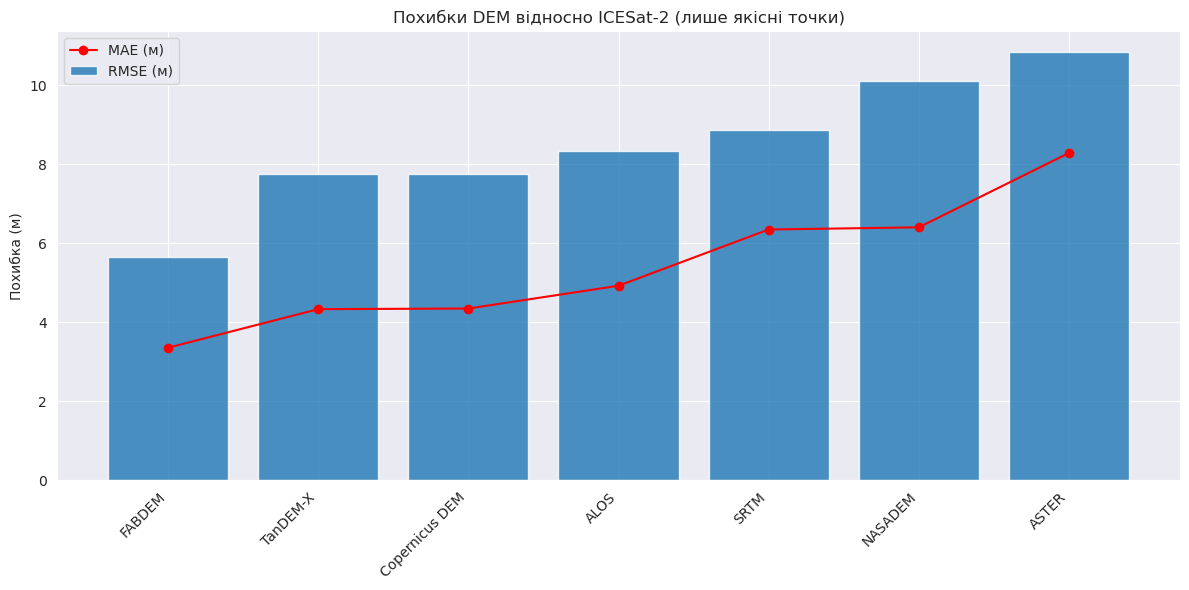

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# --- Збір статистики по DEM ---
delta_cols = [col for col in filtered.columns if col.startswith("delta_")]

dem_results = []
for col in delta_cols:
    name = col.replace("delta_", "")
    subset = filtered[col].dropna()
    if len(subset) < 10:
        continue

    mae = np.mean(np.abs(subset))
    rmse = np.sqrt(np.mean(subset**2))
    bias = np.mean(subset)
    std = np.std(subset)
    iqr = np.percentile(subset, 75) - np.percentile(subset, 25)

    dem_results.append((name, len(subset), mae, rmse, bias, std, iqr))

# --- Перетворення в DataFrame ---
df_stats = pd.DataFrame(
    dem_results,
    columns=["DEM", "n_points", "MAE", "RMSE", "Bias", "STD", "IQR"]
)

# --- Заміна технічних назв ---
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dеm": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}
df_stats["DEM_readable"] = df_stats["DEM"].map(dem_name_map).fillna(df_stats["DEM"])

# --- Вивід таблиці ---
print(df_stats[["DEM_readable", "n_points", "MAE", "RMSE", "Bias", "STD", "IQR"]])

# --- Збереження ---
df_stats.to_csv("output/dem_comparison_metrics.csv", index=False)
df_stats.sort_values(by="MAE", inplace=True)
# --- Побудова графіку ---
plt.figure(figsize=(12, 6))
plt.bar(df_stats["DEM_readable"], df_stats["RMSE"], label="RMSE (м)", alpha=0.8)
plt.plot(df_stats["DEM_readable"], df_stats["MAE"], marker="o", color="red", label="MAE (м)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Похибка (м)")
plt.title("Похибки DEM відносно ICESat-2 (лише якісні точки)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
import pandas as pd
df_stat = pd.read_csv("output/dem_comparison_metrics.csv")



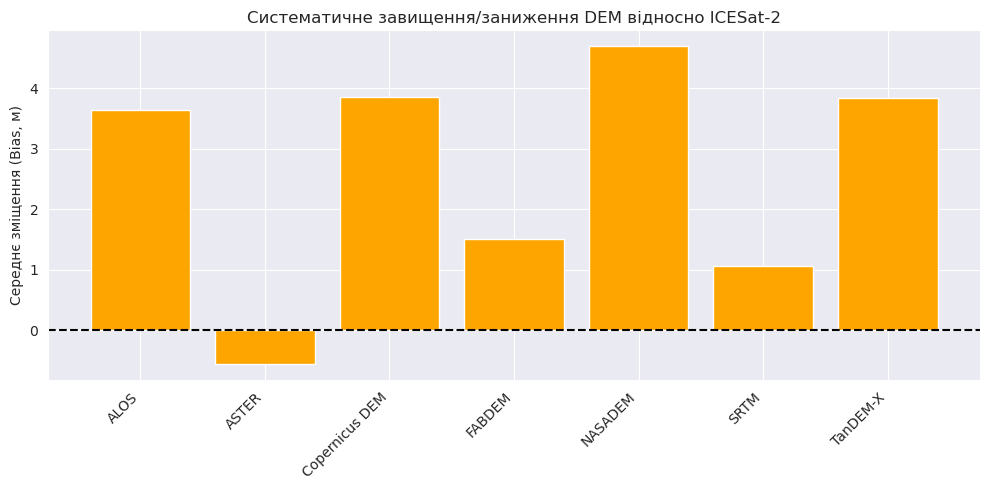

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(df_stat["DEM_readable"], df_stat["Bias"], color="orange")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Середнє зміщення (Bias, м)")
plt.title("Систематичне завищення/заниження DEM відносно ICESat-2")
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


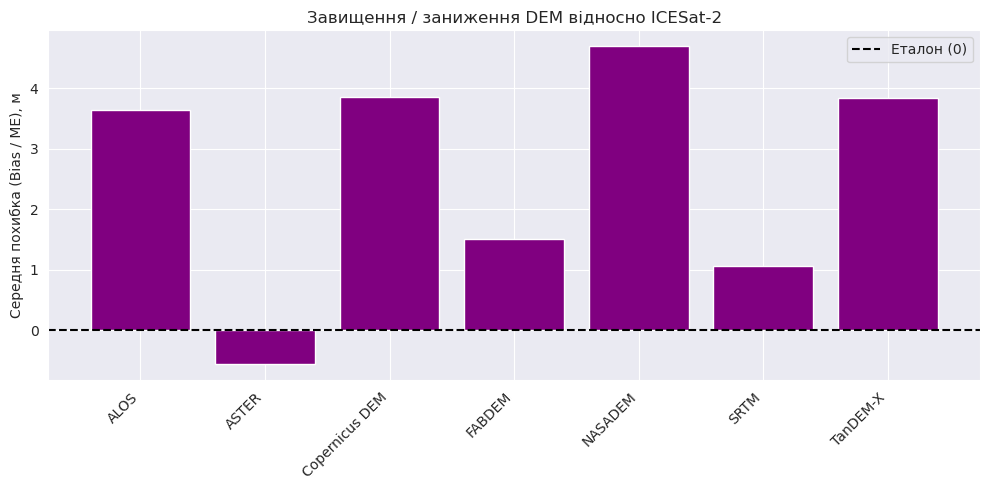

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(df_stat["DEM_readable"], df_stat["Bias"], color="purple")
plt.axhline(0, color="black", linestyle="--", label="Еталон (0)")
plt.ylabel("Середня похибка (Bias / ME), м")
plt.title("Завищення / заниження DEM відносно ICESat-2")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import pandas as pd
import numpy as np
from xdem.spatialstats import nmad

# 1. Отримати колонки з похибками DEM
delta_cols = [col for col in filtered.columns if col.startswith("delta_")]

# 2. Розрахунок статистики для кожного DEM
dem_stats = []
for col in delta_cols:
    name = col.replace("delta_", "")
    subset = filtered[col].dropna().values

    if len(subset) < 10:
        continue

    mae = np.mean(np.abs(subset))
    rmse = np.sqrt(np.mean(subset**2))
    bias = np.mean(subset)
    mede = np.median(subset)
    std = np.std(subset)
    iqr = np.percentile(subset, 75) - np.percentile(subset, 25)
    nmad_val = nmad(subset)

    dem_stats.append((name, len(subset), mae, rmse, bias, mede, std, nmad_val, iqr))

# 3. Створення DataFrame
df_stat = pd.DataFrame(
    dem_stats,
    columns=["DEM", "n_points", "MAE", "RMSE", "Bias", "MedE", "STD", "NMAD", "IQR"]
)

# 4. Мапінг назв
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dеm": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"
}
df_stat["DEM_readable"] = df_stat["DEM"].map(dem_name_map).fillna(df_stat["DEM"])

# 5. Текстова інтерпретація зміщення
df_stat["Bias_Trend"] = df_stat["Bias"].apply(
    lambda x: "Завищує DEM" if x > 0.3 else "Занижує DEM" if x < -0.3 else "Нейтральний"
)

# 6. Вивід
print(df_stat[["DEM_readable", "n_points", "MAE", "RMSE", "Bias", "MedE", "STD", "NMAD", "IQR", "Bias_Trend"]])


     DEM_readable  n_points       MAE       RMSE      Bias      MedE  \
0            ALOS    174791  4.928799   8.346951  3.633087  1.566935   
1           ASTER    174791  8.289666  10.837306 -0.570298 -3.254509   
2  Copernicus DEM    174791  4.351770   7.763542  3.860267  1.579325   
3          FABDEM    174791  3.360530   5.646605  1.498931  0.740885   
4         NASADEM    174791  6.407818  10.115402  4.694356  1.606809   
5            SRTM    174791  6.352571   8.864923  1.053086 -2.016745   
6        TanDEM-X    174791  4.335528   7.746860  3.837859  1.570292   

         STD      NMAD        IQR   Bias_Trend  
0   7.514803  3.385982   5.124699  Завищує DEM  
1  10.822290  7.690359  11.550625  Занижує DEM  
2   6.735795  2.329656   3.667485  Завищує DEM  
3   5.444020  2.466533   3.354319  Завищує DEM  
4   8.960155  5.249122   8.974585  Завищує DEM  
5   8.802151  5.149135   9.117188  Завищує DEM  
6   6.729390  2.326398   3.650933  Завищує DEM  


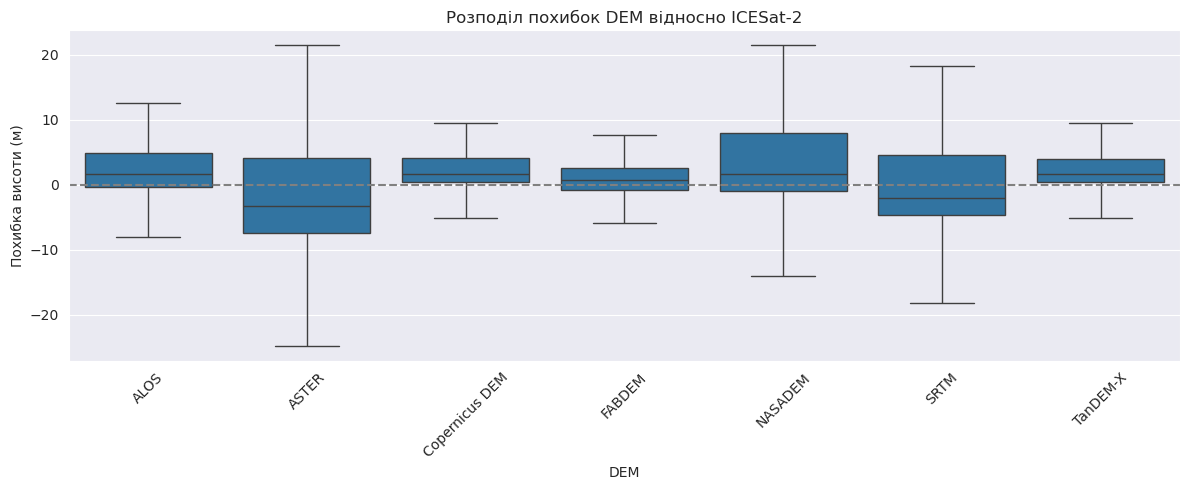

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Підготовка даних у long format
long_df = pd.melt(filtered,
                  id_vars=[],
                  value_vars=delta_cols,
                  var_name='DEM',
                  value_name='error')
long_df["DEM"] = long_df["DEM"].str.replace("delta_", "")
long_df["DEM"] = long_df["DEM"].map(dem_name_map).fillna(long_df["DEM"])

plt.figure(figsize=(12, 5))
sns.boxplot(data=long_df, x="DEM", y="error", showfliers=False)
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Похибка висоти (м)")
plt.title("Розподіл похибок DEM відносно ICESat-2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
df_stat.to_csv("output/dem_icesat_metrics.csv", index=False)
